In [ ]:
# Montar Google Drive e ingresar la carpeta donde están los .txt
from google.colab import drive
import os
drive.mount('/content/drive')

# Verifica visualmente las carpetas y copia la ruta correcta:
# !ls /content/drive/MyDrive

# Establece aquí la carpeta donde están los .txt
carpeta_entrevistas = '/content/drive/MyDrive/_Luz Stella Doctorado/Mario Chamie Mazilli/2_transcripciones_Archivos .txt'  # ← Cambiar si es necesario
assert os.path.exists(carpeta_entrevistas), f'Ruta no válida: {carpeta_entrevistas}'
os.getcwd()
os.chdir(carpeta_entrevistas)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.getcwd()

'/content/drive/MyDrive/_Luz Stella Doctorado/Mario Chamie Mazilli/2_transcripciones_Archivos .txt'

# Notebook Maestro: Análisis temático y de sentimiento en entrevistas

Este notebook permite:
- Procesar múltiples entrevistas (.txt)
- Calcular frecuencias y exportarlas a .csv
- Construir una matriz documento-término (TF-IDF)
- Realizar análisis de sentimiento
- Aplicar clustering temático
- Visualizar resultados

## 1. Instalar e importar librerías necesarias

In [ ]:
!pip install -q nltk scikit-learn textblob
!python -m textblob.download_corpora

import nltk
import os
import pandas as pd
import re
from collections import Counter
from nltk.corpus import stopwords
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

nltk.download('stopwords')
stopwords_esp = set(stopwords.words('spanish'))

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## 2. Subir múltiples archivos `.txt`

In [ ]:
from google.colab import files
uploaded = files.upload()
txt_files = [f for f in uploaded if f.endswith('.txt')]

Saving Voz 035.txt to Voz 035 (1).txt
Saving Voz 036.txt to Voz 036 (1).txt
Saving Voz_Prueba_Piloto_01.txt to Voz_Prueba_Piloto_01 (1).txt


## 3. Procesar cada archivo: frecuencias, sentimiento y guardar CSV

In [ ]:
datos = []
corpus = []

for archivo in txt_files:
    with open(archivo, 'r', encoding='utf-8') as f:
        texto = f.read()
        corpus.append(texto)

    # Tokenización simple
    palabras = re.findall(r'\b\w+\b', texto.lower())
    tokens = [p for p in palabras if p not in stopwords_esp]
    frecuencias = Counter(tokens)

    # Exportar CSV por archivo
    df_frec = pd.DataFrame(frecuencias.items(), columns=['palabra', 'frecuencia'])
    df_frec['archivo'] = archivo
    df_frec.to_csv(archivo.replace('.txt', '_frecuencias.csv'), index=False)

    # Análisis de sentimiento con TextBlob
    sentimiento = TextBlob(texto).sentiment.polarity

    # Guardar datos básicos
    datos.append({
        'archivo': archivo,
        'texto': texto,
        'tokens': ' '.join(tokens),
        'sentimiento': sentimiento
    })

df_datos = pd.DataFrame(datos)
df_datos.to_csv("resumen_entrevistas.csv", index=False)

## 4. Construir matriz documento-término (TF-IDF)

In [ ]:
vectorizador = TfidfVectorizer()
tfidf = vectorizador.fit_transform(df_datos['tokens'])
matriz_tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizador.get_feature_names_out())
matriz_tfidf['archivo'] = df_datos['archivo']
matriz_tfidf.head()

,000,16,18,200,2000,2016,2017,30,33,45,...,víctimas,vínculo,yendo,zombra,zonas,étnicas,étnicos,étrica,éxito,archivo
0,0.058546,0.058546,0.000000,0.000000,0.019515,0.039031,0.058546,0.019515,0.039031,0.000000,...,0.014842,0.000000,0.019515,0.019515,0.000000,0.039031,0.039031,0.000000,0.039031,Voz 035 (1).txt
1,0.000000,0.000000,0.000000,0.038098,0.000000,0.000000,0.000000,0.000000,0.000000,0.028974,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.038098,0.000000,Voz 036 (1).txt
2,0.000000,0.000000,0.017682,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013447,...,0.013447,0.017682,0.000000,0.000000,0.053045,0.000000,0.000000,0.000000,0.000000,Voz_Prueba_Piloto_01 (1).txt


## 5. Análisis de Clustering con KMeans

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=0)
clusters = kmeans.fit_predict(tfidf)
df_datos['cluster'] = clusters

## 6. Visualización con PCA

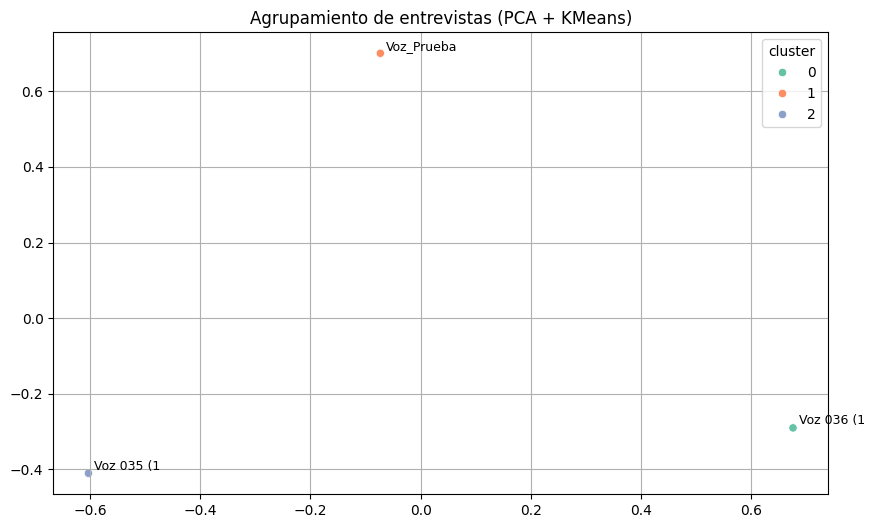

In [ ]:
pca = PCA(n_components=2)
coords = pca.fit_transform(tfidf.toarray())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=coords[:,0], y=coords[:,1], hue=df_datos['cluster'], palette='Set2')
for i, archivo in enumerate(df_datos['archivo']):
    plt.text(coords[i,0]+0.01, coords[i,1]+0.01, archivo[:10], fontsize=9)
plt.title("Agrupamiento de entrevistas (PCA + KMeans)")
plt.grid(True)
plt.show()

## 7. Visualización del sentimiento por entrevista

<ipython-input-12-de6c3f823a77>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_datos, x='archivo', y='sentimiento', palette='coolwarm')


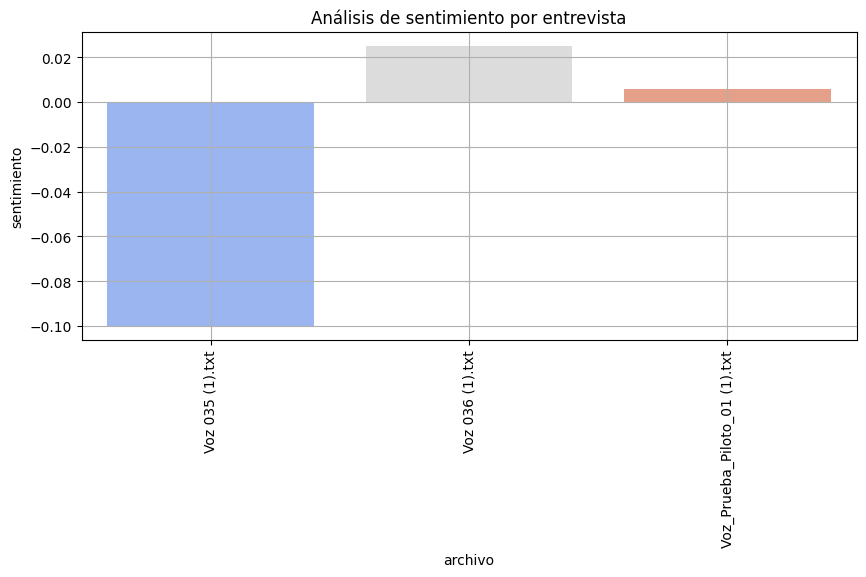

In [ ]:
plt.figure(figsize=(10,4))
sns.barplot(data=df_datos, x='archivo', y='sentimiento', palette='coolwarm')
plt.xticks(rotation=90)
plt.title("Análisis de sentimiento por entrevista")
plt.grid(True)
plt.show()

## 8. Exportar datos finales

In [ ]:
df_datos.to_csv("resultados_finales_sentimiento_clusters.csv", index=False)
print("Exportado como resultados_finales_sentimiento_clusters.csv")

Exportado como resultados_finales_sentimiento_clusters.csv


## 9. Conclusión

Este notebook maestro permite un análisis integrado de múltiples entrevistas: análisis textual, sentimiento, agrupamiento y visualizaciones. Puede extenderse a mapas temáticos, dashboards o análisis temporal si se requiere.

In [ ]:
# Tokenización y limpieza de entrevistas desde carpeta en Google Drive
import os
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Asegúrate de tener descargadas las siguientes dependencias
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')

carpeta_entrevistas = '/content/drive/MyDrive/_Luz Stella Doctorado/Mario Chamie Mazilli/2_transcripciones_Archivos .txt'  # Ajustar según tu ubicación
archivos_tokenizados = {}

for nombre_archivo in os.listdir(carpeta_entrevistas):
    if nombre_archivo.endswith('.txt'):
        with open(os.path.join(carpeta_entrevistas, nombre_archivo), 'r', encoding='utf-8') as f:
            texto = f.read().lower()
            texto = re.sub(r'[^\w\s]', '', texto)
            tokens = word_tokenize(texto, language='spanish')
            tokens = [t for t in tokens if t not in stopwords.words('spanish')]
            archivos_tokenizados[nombre_archivo] = tokens

## Objetivo Específico 1 (OE1): Análisis teórico con base en Sen, Nussbaum y Roth

<Axes: title={'center': 'Categorías Teóricas por Entrevista'}>

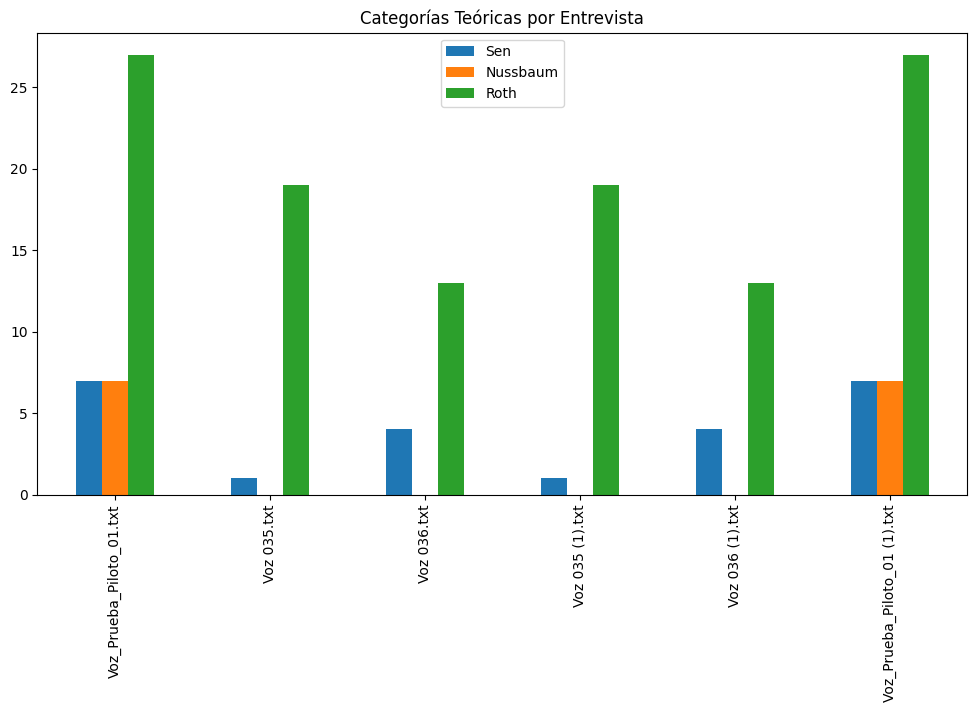

In [ ]:
# Diccionario de términos teóricos clave
diccionario_capacidades = {
    "Sen": ["libertad", "agencia", "elección", "funcionamiento", "capacidad"],
    "Nussbaum": ["dignidad", "control", "vida", "emociones", "afiliación"],
    "Roth": ["participación", "responsabilidad", "territorio", "política", "planeación"]
}

# Conteo de términos por autor en cada entrevista
frecuencias_autores = {}
for archivo, tokens in archivos_tokenizados.items():
    contador = {}
    for autor, palabras in diccionario_capacidades.items():
        contador[autor] = sum(tokens.count(pal) for pal in palabras)
    frecuencias_autores[archivo] = contador

import pandas as pd
df_autores = pd.DataFrame.from_dict(frecuencias_autores, orient='index')
df_autores.plot(kind='bar', figsize=(12, 6), title="Categorías Teóricas por Entrevista")

## Objetivo Específico 2 (OE2): Clustering temático entre tipos de actor

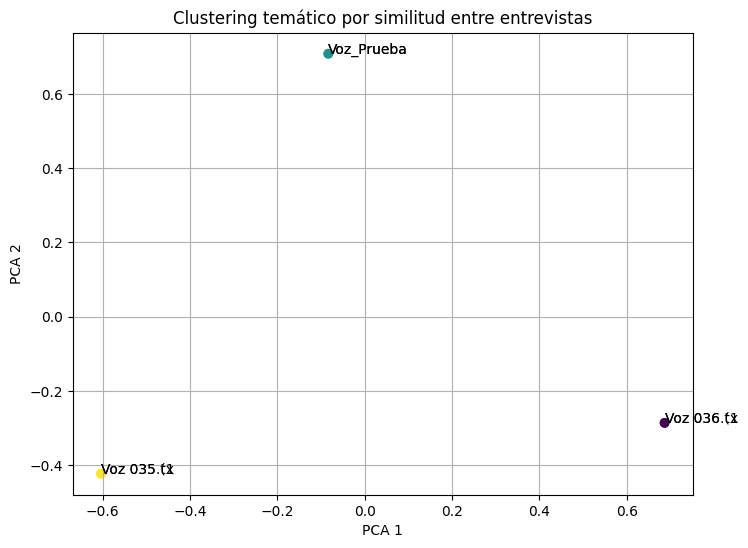

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reconstruir textos a partir de tokens
documentos = [' '.join(tokens) for tokens in archivos_tokenizados.values()]
nombres_archivos = list(archivos_tokenizados.keys())

# Crear matriz TF-IDF (solo valores numéricos)
vectorizer = TfidfVectorizer()
matriz_tfidf = vectorizer.fit_transform(documentos)

# Similaridad y clustering
cos_sim = cosine_similarity(matriz_tfidf)
kmeans = KMeans(n_clusters=3, random_state=42).fit(matriz_tfidf)

# Visualización con PCA
pca = PCA(n_components=2)
coords = pca.fit_transform(matriz_tfidf.toarray())
plt.figure(figsize=(8, 6))
plt.scatter(coords[:, 0], coords[:, 1], c=kmeans.labels_)

# Etiquetas opcionales con nombres de archivos
for i, nombre in enumerate(nombres_archivos):
    plt.annotate(nombre[:10], (coords[i, 0], coords[i, 1]))

plt.title("Clustering temático por similitud entre entrevistas")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()

## Objetivo Específico 3 (OE3): Análisis de expresiones de autonomía y agencia

<Axes: title={'center': 'Expresiones de autonomía por entrevista'}>

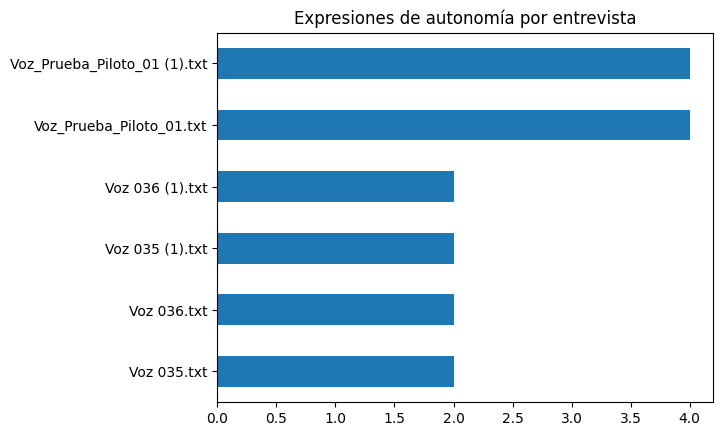

In [ ]:
# Palabras clave asociadas a agencia/autonomía
frases_autonomia = ["decidir", "controlar", "participar", "vivir con dignidad", "liderar"]

# Conteo de expresiones por archivo
autonomia_por_entrevista = {
    archivo: sum(token in frases_autonomia for token in tokens)
    for archivo, tokens in archivos_tokenizados.items()
}

pd.Series(autonomia_por_entrevista).sort_values().plot(kind='barh', title="Expresiones de autonomía por entrevista")